In [431]:
from utilities import *
import h5py
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
import os
!pip install opencv-python==4.4.0.46

In [432]:
# Definimos conjuntos de training y test.

files = os.listdir("Preprocesado/Heridas/Originales")
cantidad_imagenes = len(files)

size_test = int(0.4*cantidad_imagenes)
size_train = cantidad_imagenes-size_test

indexes = list(range(0,cantidad_imagenes))

index_train = list(np.random.choice(indexes, size_train, False))
index_test = list(np.setdiff1d(indexes,index_train))

heridas_recortadas = [Imagen("Preprocesado/Heridas/Originales/" + str(i+1) + ".jpg").cut(save = False, output_path = "Preprocesado/Heridas/Recortados/" + str(i+1) + ".png") for i in range(len(files))]

sanos_recortados = [Imagen("Preprocesado/Sanos/Originales/" + str(i+1) + ".jpg").cut(save = True, output_path = "Preprocesado/Sanos/Recortados/" + str(i+1) + ".png") for i in range(len(files))]

heridas_recortadas_train = [heridas_recortadas[i] for i in index_train]
sanos_recortados_train = [sanos_recortados[i] for i in index_train]

heridas_recortadas_test = [heridas_recortadas[i] for i in index_test]
sanos_recortados_test = [sanos_recortados[i] for i in index_test]

In [433]:
# Hemos de aumentar train y test por separado.

new_heridas_recortadas_train = []
new_heridas_recortadas_test = []
num_new_images = 50

for i in range(len(heridas_recortadas_train)):

    dim_img = heridas_recortadas_train[i].shape[0]
    samples = np.expand_dims(heridas_recortadas_train[i], 0)
    datagen = ImageDataGenerator(width_shift_range = 0.2, height_shift_range = 0.2, horizontal_flip = True, rotation_range = 90)
    it = datagen.flow(samples, batch_size = 1)

    for j in range(num_new_images):
        batch = it.next()
        image = batch[0].astype('uint8')
        image_new = processing(img_inj = image, img_healthy = sanos_recortados_train[i])
        new_heridas_recortadas_train.append(image_new)

for i in range(len(heridas_recortadas_test)):

    dim_img = heridas_recortadas_test[i].shape[0]
    samples = np.expand_dims(heridas_recortadas_test[i], 0)
    datagen = ImageDataGenerator(width_shift_range = 0.2, height_shift_range = 0.2, horizontal_flip = True, rotation_range = 90)
    it = datagen.flow(samples, batch_size = 1)

    for j in range(num_new_images):
        batch = it.next()
        image = batch[0].astype('uint8')
        image_new = processing(img_inj = image, img_healthy = sanos_recortados_test[i])
        new_heridas_recortadas_test.append(image_new)

In [434]:
# Ahora hemos de preprocesar también las imágenes originales y luego concatenar ambas listas (la original y la creada)

for i in range(len(heridas_recortadas_train)):
    heridas_recortadas_train[i] = processing(img_inj = heridas_recortadas_train[i], img_healthy = sanos_recortados_train[i])

for i in range(len(heridas_recortadas_test)):
    heridas_recortadas_test[i] = processing(img_inj = heridas_recortadas_train[i], img_healthy = sanos_recortados_train[i])

data_augmented_train = heridas_recortadas_train + new_heridas_recortadas_train
data_augmented_test = heridas_recortadas_test + new_heridas_recortadas_test

In [435]:
# Ahora consideraremos hacer un resize y las pondremos todas en el mismo array.

new_dim_train = int(round(np.mean([data_augmented_train[i].shape[0] for i in range(len(data_augmented_train))])))
new_dim_test = int(round(np.mean([data_augmented_test[i].shape[0] for i in range(len(data_augmented_test))])))
#new_dim = int(round(np.mean(new_dim_train+new_dim_test)))
new_dim = 100

new_data_augmented_train = np.stack([resize(data_augmented_train[i], shape_input = (new_dim, new_dim)) for i in range(len(data_augmented_train))], axis = 0)
new_data_augmented_test = np.stack([resize(data_augmented_test[i], shape_input = (new_dim, new_dim)) for i in range(len(data_augmented_test))], axis = 0)

In [436]:
# Ahora hemos de sacar las etiquetas del CSV.

data = pd.read_csv("Leucoplasia307.csv")

labels = np.array(data["Evolucioncancer"].values)
milabel = np.array(data["MiLabel"].values)

indices = np.where(milabel > 0)[0]
labels = list(labels[indices])
labels_train = [labels[i] for i in index_train]
labels_test = [labels[i] for i in index_test]
length_train = len(labels_train)
length_test = len(labels_test)

# No obstante estas etiquetas son únicamente las de las imágenes originales y necesitamos etiquetar también las obtenidas mediante Data Augmentation.

for i in range(length_train):
    labels_train = labels_train + [labels_train[i] for j in range(num_new_images)]

for i in range(length_test):
    labels_test = labels_test + [labels_test[i] for j in range(num_new_images)]

labels_train = np.array(labels_train)
labels_test = np.array(labels_test)

In [437]:
# Del mismo CSV también queremos extraer la histologia.
# No obstante, por ahora no se usará puesto que no tenemos demasiadas imágenes...

histologia = np.array(data["Histologia"].values)
histologia = list(histologia[indices])
histologia_train = [histologia[i] for i in index_train]
histologia_test = [histologia[i] for i in index_test]

for i in range(length_train):
    histologia_train = histologia_train + [histologia_train[i] for j in range(num_new_images)]

for i in range(length_test):
    histologia_test = histologia_test + [histologia_test[i] for j in range(num_new_images)]

histologia_train = pd.get_dummies(histologia_train)
histologia_train = np.array(histologia_train)

histologia_test = pd.get_dummies(histologia_test)
histologia_test = np.array(histologia_test)

In [438]:
# Definamos conjuntos de entrenamiento y test para un modelo funcional.

X_train1 = new_data_augmented_train
y_train1 = labels_train
X_test1 = new_data_augmented_test
y_test1 = labels_test

X_train2 = histologia_train
X_test2 = histologia_test

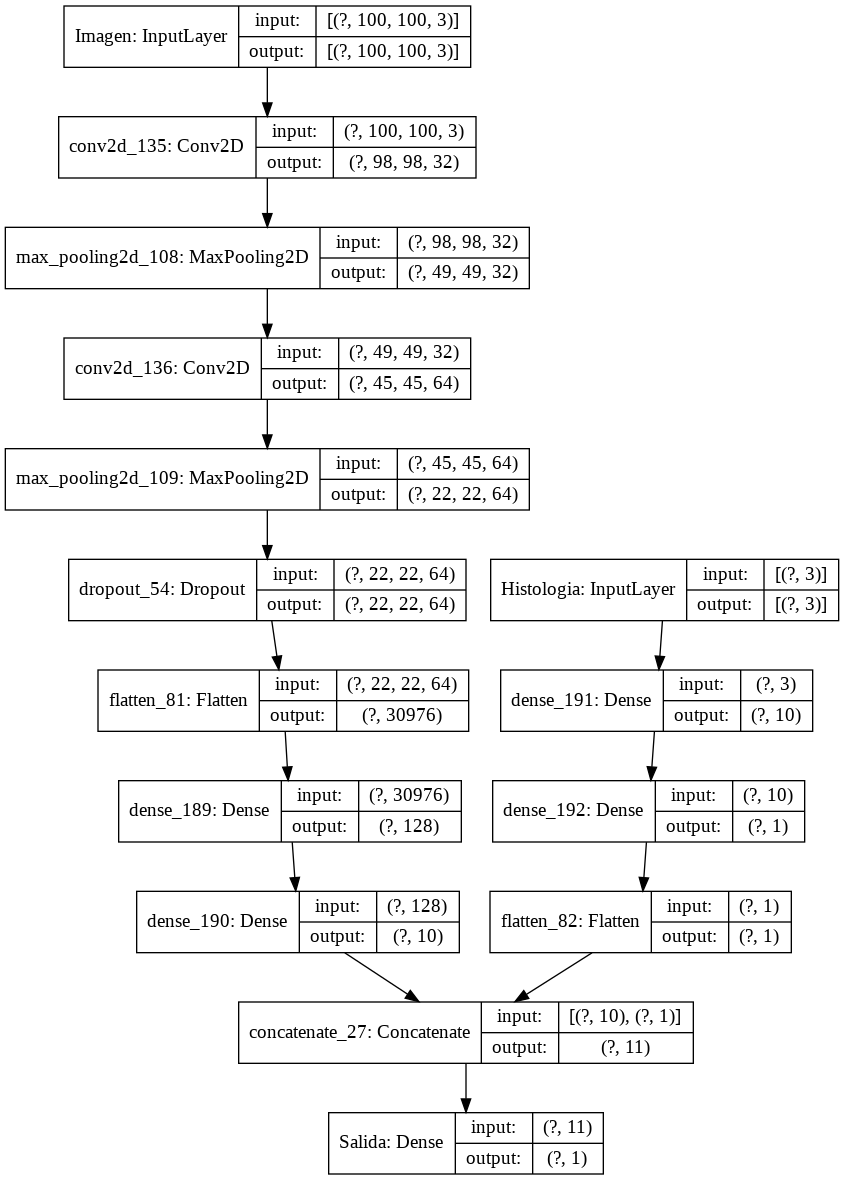

In [439]:
# Hemos de considerar también la histología para lo cual haremos un modelo funcional.

import keras
from keras.layers import Conv2D, MaxPooling2D, Flatten
from keras.layers import Input, LSTM, Embedding, Dense, Dropout
from keras.models import Model, Sequential
from keras.regularizers import l1, l2

# Crearemos el modelo funcional.

# CNN para el input imagen:

imagen_input = Input(shape = (X_train1.shape[1], X_train1.shape[2],3), name = "Imagen")
conv1 = Conv2D(32, kernel_size=3, activation = "relu")(imagen_input)
maxpooling1 = MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(64, kernel_size=5, activation = "relu", activity_regularizer=l2(0.001))(maxpooling1)
maxpooling2 = MaxPooling2D(pool_size=(2, 2))(conv2)
dropout3 = Dropout(0.3)(maxpooling2)
flatten1 = Flatten()(dropout3)
densa3 = Dense(128, activation = "relu", activity_regularizer=l2(0.01))(flatten1)
salida_imagen = Dense(10, activation = "relu")(densa3)

# MLP para el input categórico:

histologia_input = Input(shape=X_train2.shape[1], dtype = "int32", name = "Histologia")
densa1 = Dense(10, activation = "relu", activity_regularizer=l2(0.001))(histologia_input)
densa2 = Dense(1, activation = "sigmoid")(densa1)
salida_cat = Flatten()(densa2)

merged = keras.layers.concatenate([salida_imagen, salida_cat])
output = Dense(1, activation = "sigmoid", name = "Salida")(merged)

inception_module = Model(inputs = [imagen_input, histologia_input], outputs = output)

# Mostramos un esquema

from keras.utils.vis_utils import plot_model
plot_model(inception_module, show_shapes = True)

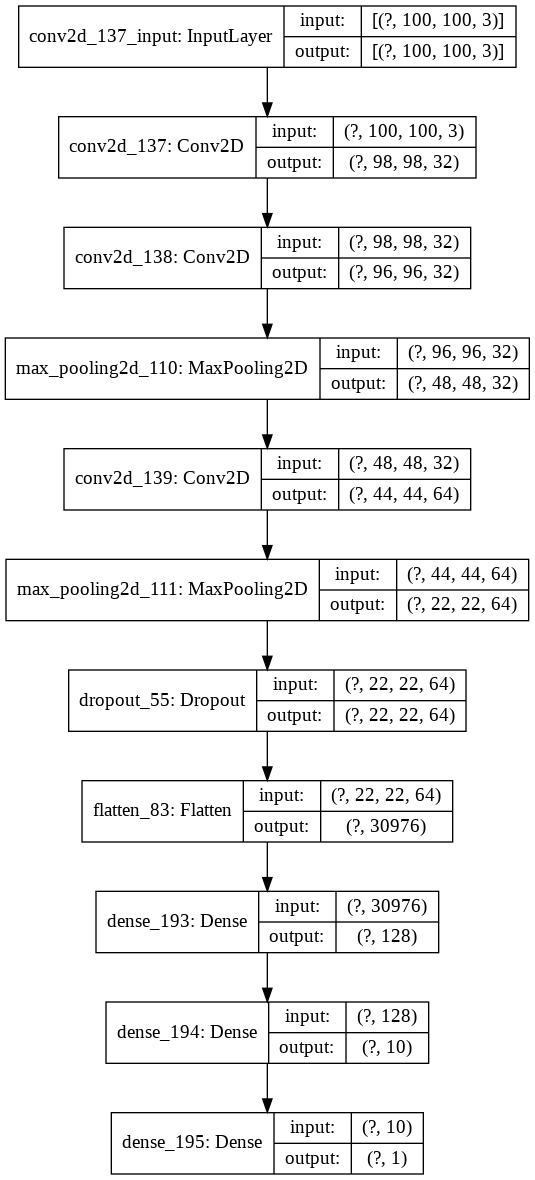

In [440]:
# Haremos un modelo secuencial sin usar la histología porque no tenemos suficientes valores.

from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(X_train1.shape[1], X_train1.shape[2], 3)))
model.add(Conv2D(32, kernel_size=3, activation = "relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=5, activation = "relu", activity_regularizer=l2(0.001)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation = "relu", activity_regularizer=l2(0.01)))
model.add(Dense(10, activation = "relu"))
model.add(Dense(1, activation = "sigmoid"))

from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes = True)

In [441]:
model.compile(optimizer="adam", loss='binary_crossentropy',
              metrics=["accuracy"])
model.fit(X_train1, y_train1, epochs=20, validation_data=(X_test1, y_test1))

Epoch 1/20
13/13 [==============================] - 1s 44ms/step - loss: 0.6390 - accuracy: 0.7304 - val_loss: 0.8991 - val_accuracy: 0.4000
Epoch 2/20
13/13 [==============================] - 0s 29ms/step - loss: 0.5246 - accuracy: 0.7500 - val_loss: 0.9535 - val_accuracy: 0.4000
Epoch 3/20
13/13 [==============================] - 0s 29ms/step - loss: 0.4841 - accuracy: 0.7500 - val_loss: 0.9580 - val_accuracy: 0.4000
Epoch 4/20
13/13 [==============================] - 0s 29ms/step - loss: 0.4069 - accuracy: 0.7500 - val_loss: 0.8831 - val_accuracy: 0.4000
Epoch 5/20
13/13 [==============================] - 0s 29ms/step - loss: 0.3408 - accuracy: 0.8186 - val_loss: 1.1135 - val_accuracy: 0.4392
Epoch 6/20
13/13 [==============================] - 0s 29ms/step - loss: 0.2714 - accuracy: 0.9510 - val_loss: 1.1006 - val_accuracy: 0.4784
Epoch 7/20
13/13 [==============================] - 0s 30ms/step - loss: 0.2404 - accuracy: 0.9853 - val_loss: 1.3708 - val_accuracy: 0.4549
Epoch 8/20
13

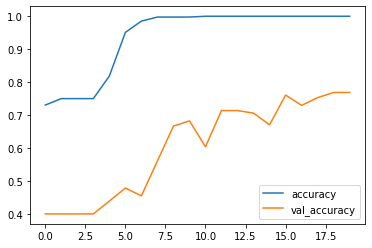

In [442]:
import matplotlib.pyplot as plt

%matplotlib inline

plt.figure
plt.plot(model.history.history['accuracy'],label="accuracy")
plt.plot(model.history.history['val_accuracy'],label="val_accuracy")
plt.legend()
plt.show()

In [443]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test1)

y_pred = np.array([1 if y_pred[i] >= 0.5 else 0 for i in range(len(y_pred))])

confusion_matrix(y_test1, y_pred)

array([[ 93,   9],
       [ 50, 103]])

In [444]:
import h5py

hf = h5py.File("dataset_90acc.h5", "w")
hf.create_dataset("X_train1", data = X_train1)
hf.create_dataset("y_train1", data = y_train1)
hf.create_dataset("X_test1", data = X_test1)
hf.create_dataset("y_test1", data = y_test1)
hf.close()

In [445]:
model.save("model_90acc.h5")

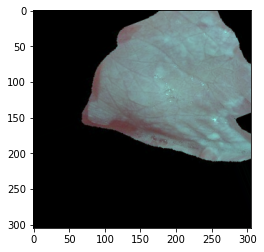

In [446]:
plt.imshow(data_augmented_train[20])